In [1]:
import pandas as pd
import numpy as np

from random import randrange
import pickle 
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

import datetime

import hdbscan
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pprint
import pathlib
import os

import warnings
warnings.filterwarnings('ignore')

### Load data

In [2]:
df = pd.read_pickle('data/nem_formatted_data.pkl')
df = df.sort_values(['state', 'datetime'])

# Remove 1st Oct 2020 as the data is not complete
df = df[df.datetime.dt.date.astype('str') != '2020-10-01']

In [3]:
fuel_cols = ['wind', 'solar', 'solar_rooftop', 'blackcoal', 'browncoal','gas','diesel','kerosene','hydro','bagasse','batterys', 'net_import']
index_cols = [ 'state', 'datetime'] 

In [4]:
X = df[fuel_cols]

In [ ]:
df.datetime.max()

In [6]:
X.shape

(18110, 12)

### Make directory

In [7]:
os.makedirs('models')
os.makedirs('results')

### Baysian gaussian optimal cluster count

#### Run model for different prior and limit on cluster components

In [ ]:
for alpha in [0.5, 1, 5, 10, 100, 1000]:
    n_components = np.arange(2, 101)
    models =[]
    for n in n_components:
        print('processing n {}'.format(n))
        models.append(BayesianGaussianMixture(n_components = n, 
                                              covariance_type='full', 
                                              random_state=2020,
                                              max_iter = 1000,
                                              weight_concentration_prior_type ='dirichlet_process',
                                              weight_concentration_prior = alpha).fit(X))
# Save the models
pickle.dump(models, open('models/bgmm_1_100_alpha{}.pkl'.format(alpha), 'wb'))

processing n 2
processing n 3
processing n 4
processing n 5
processing n 6
processing n 7
processing n 8
processing n 9
processing n 10
processing n 11
processing n 12
processing n 13
processing n 14
processing n 15
processing n 16
processing n 17
processing n 18
processing n 19
processing n 20
processing n 21
processing n 22
processing n 23
processing n 24
processing n 25
processing n 26
processing n 27
processing n 28
processing n 29
processing n 30
processing n 31
processing n 32
processing n 33
processing n 34
processing n 35
processing n 36
processing n 37
processing n 38
processing n 39
processing n 40
processing n 41


#### Evaluate model

In [7]:
# Create dataframe with columns ['alpha', 'N', 'True_N', 'converged', 'loglik']
result = []
for alpha in [0.5, 1, 5, 10, 100, 1000]:
    models = pickle.load(open('models/bgmm_1_100_alpha{}.pkl'.format(alpha), 'rb'))
    
    for idx, m in enumerate(models):
        labels=m.predict(X)
        components = len(np.unique(labels)) # get number of components
        result.append([alpha, idx + 2, components, m.converged_, m.score(X)])
cols = ['alpha', 'N', 'True_N', 'converged', 'loglik']
result = pd.DataFrame(result, columns = cols)
result['conv'] = 'no'
result.loc[result.converged == True, 'conv'] = 'yes'
result.to_csv('models/bgmm_results.csv', index = False)
result['conv'] = result['conv'].astype('category')

In [8]:
pickle.dump(result, open('models/bgmm_results.pkl', 'wb'))

### Plot predicted cluster components for different alpha settings

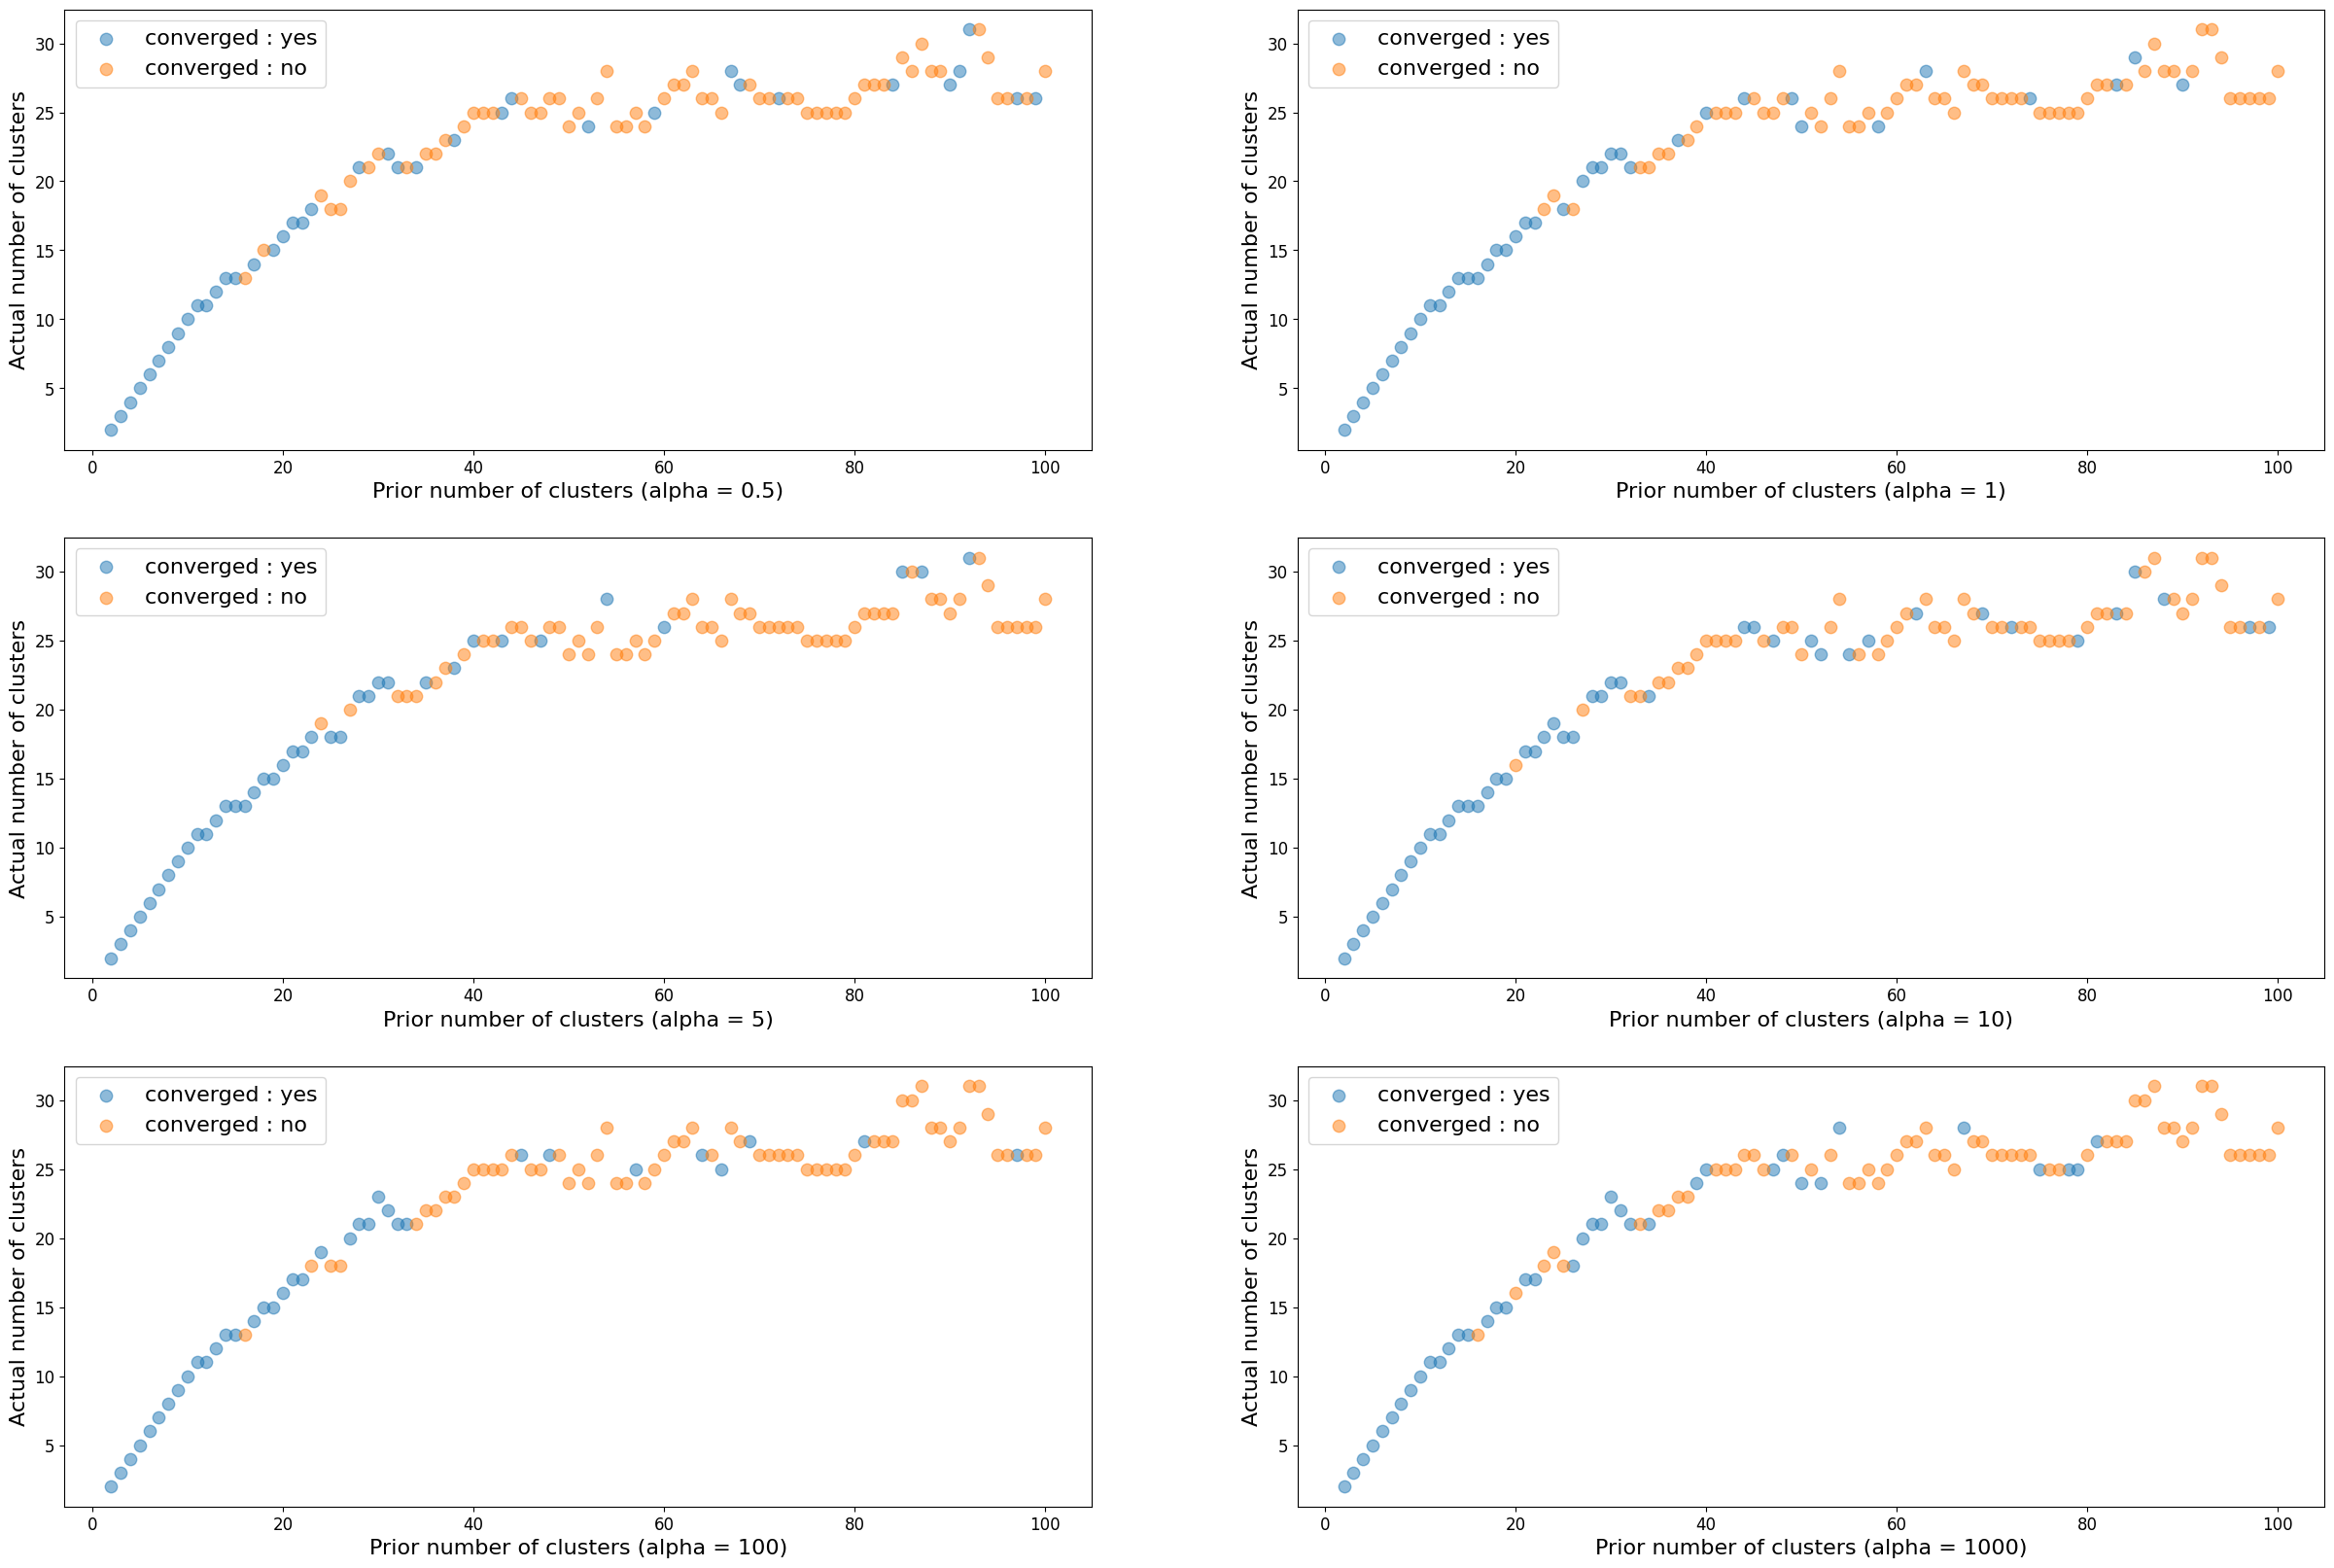

In [9]:
plt.style.use('default')
fig, ax = plt.subplots(3, 2, figsize=(30,20))

def plot_optimal_cluster_all(alpha, idx):
    sub_result = result[result.alpha == alpha]
    s1 = sub_result[sub_result.converged == True]
    s2 = sub_result[sub_result.converged == False]
    ax[idx].scatter(s1['N'], s1['True_N'], label='converged : yes', s=80, alpha = 0.5)
    ax[idx].scatter(s2['N'], s2['True_N'], label='converged : no', s=80, alpha = 0.5)
    ax[idx].legend(loc='best', fontsize = 16)
    ax[idx].set_xlabel('Prior number of clusters (alpha = {})'.format(alpha))
    ax[idx].set_ylabel('Actual number of clusters')
    ax[idx].xaxis.label.set_size(16)
    ax[idx].yaxis.label.set_size(16)
    ax[idx].tick_params(axis='both', which='major', labelsize=12)


plot_optimal_cluster_all(0.5, (0,0))
plot_optimal_cluster_all(1, (0,1))
plot_optimal_cluster_all(5, (1,0))
plot_optimal_cluster_all(10, (1,1))
plot_optimal_cluster_all(100, (2,0))
plot_optimal_cluster_all(1000, (2,1))

### Plot for alpha = 5, until 50. Also plot loglikihood and number of components v/s acutal clusters

In [ ]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(15,5))

cut_off = 50

def plot_optimal_cluster(alpha, annotate):
    sub_result = result[(result.alpha == alpha) & (result.N <= cut_off)]
    x = np.array(sub_result['N'])
    y = np.array(sub_result['True_N'])
    txts = ["[{},{}]".format(a,b) for a,b in zip(x,y)]

    s1 = sub_result[sub_result.converged == True]
    s2 = sub_result[sub_result.converged == False]
    ax.plot(x, y)
    ax.plot(x, sub_result['loglik'], c ='green')
    ax.scatter(s1['N'], s1['True_N'], label='converged : yes', s=80, alpha = 0.5)
    ax.scatter(s2['N'], s2['True_N'], label='converged : no', s=80, alpha = 0.5)
    if annotate:
        for i, txt in enumerate(txts):
            ax.annotate(txt, (x[i], y[i]), rotation = 70)
    ax.legend(loc='best')
    ax.set_xlabel('Prior number of clusters (alpha = {})'.format(alpha))
    ax.set_ylabel('Actual number of clusters')
    ax.xaxis.label.set_size(14)
    ax.yaxis.label.set_size(14)
    ax.tick_params(axis='both', which='major', labelsize=10)


    
plot_optimal_cluster(5, True)

### Plot predicted cluster components count for different alpha settings

In [11]:
result =  pickle.load(open('models/bgmm_results.pkl', 'rb'))
result = result[result.conv == 'yes']

Text(0, 0.5, 'Count')

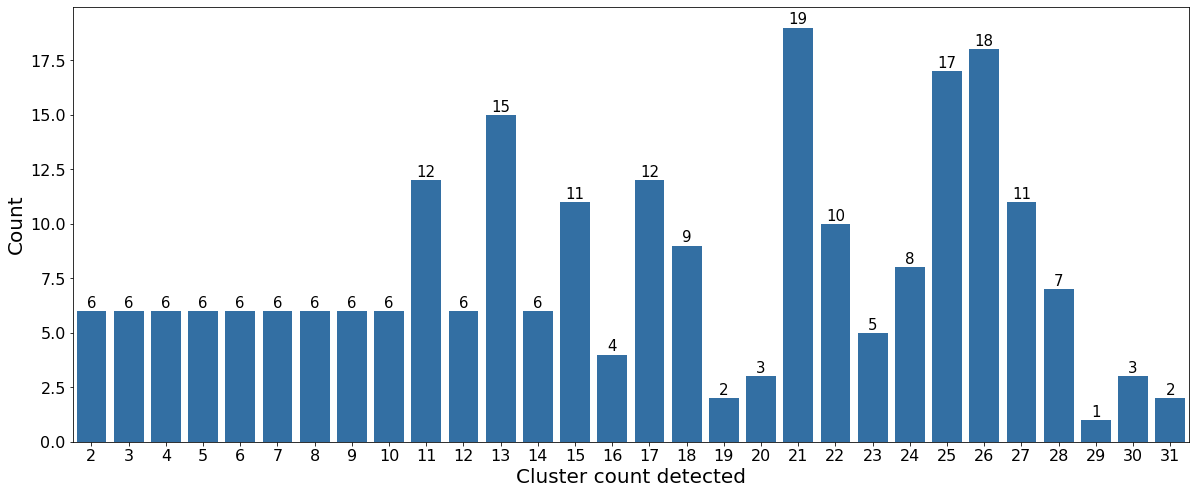

In [82]:
sub_result = result.groupby(['True_N']).size().reset_index(name='Count')

# Plot bar
# plt.figure(figsize=(20, 8)) 
fig, ax = plt.subplots(figsize=(20,8))
g = sns.barplot(x="True_N", y="Count", color ='#2171b5', data=sub_result)

# https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/
for bar in g.patches: 
    g.annotate(int(bar.get_height()),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=15, xytext=(0, 8), 
                   textcoords='offset points') 

g.set_yticklabels(g.get_yticks(), size=16)
g.set_xticklabels(np.sort(sub_result.True_N.unique()), size=16)
plt.xlabel("Cluster count detected", size=20) 
plt.ylabel("Count", size=20) 

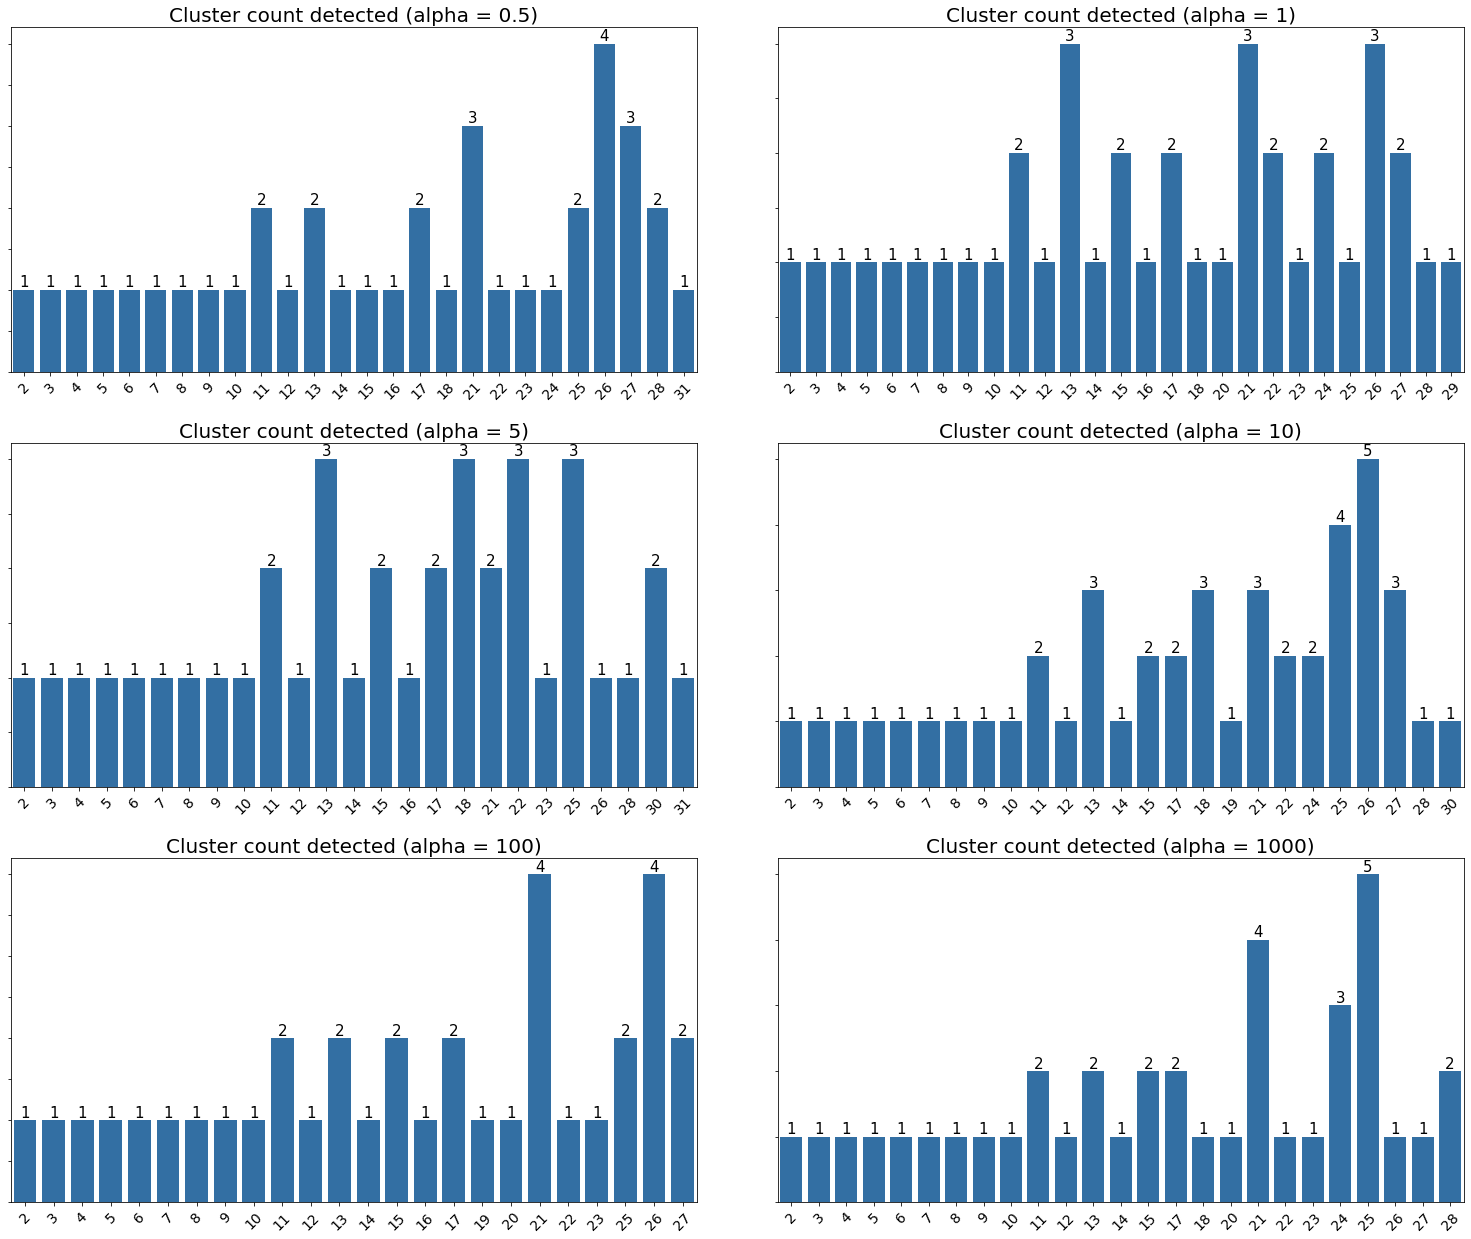

In [89]:
sub_result = result.groupby(['alpha', 'True_N']).size().reset_index(name='Count')

# Plot bar
fig, ax = plt.subplots(3, 2, figsize=(22,18))
fig.tight_layout(pad=5.0)

def plot_cluster_count(alpha, idx):
    sr = sub_result[sub_result.alpha == alpha]
    g = sns.barplot(x="True_N", y="Count", color ='#2171b5', data=sr, ax = ax[idx])
    
    # https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/
    for bar in g.patches: 
        g.annotate(int(bar.get_height()),  
                       (bar.get_x() + bar.get_width() / 2,  
                        bar.get_height()), ha='center', va='center', 
                       size=15, xytext=(0, 8), 
                       textcoords='offset points')
    g.set_yticklabels([], size=14)
    g.set_xticklabels(np.sort(sr.True_N.unique()), size=14, rotation = 45)
    g.set_title("Cluster count detected (alpha = {})".format(alpha), size=20)
    g.set(xlabel=None)
    g.set(ylabel=None)


plot_cluster_count(0.5, (0,0))
plot_cluster_count(1, (0,1))
plot_cluster_count(5, (1,0))
plot_cluster_count(10, (1,1))
plot_cluster_count(100, (2,0))
plot_cluster_count(1000, (2,1))
